Scattering theory can be used to compute what happens when a beam of electrons is fired towards a target object. The electrons collide with the object and are scattered off in new directions. The angular distribution of the outgoing electrons is described by a sum of contributions, in which the simplest term corresponds to an isotropic distribution.

If the energy of the incoming electron is not too large, then this isotropic contribution dominates the distribution. This situation is called s-wave scattering.

The electrons are incident on a target that is located at the origin and is decribed by an isotropic interaction potential $U(r)$. The time-independent Schrodinger equation for the outgoing electrons has a general solution
\begin{equation}
    \psi(r, \theta) = \sum_{l=0}^\infty \frac{\chi_{\ell}(r)}{r} P_{\ell}(\cos\theta),
\end{equation}
where $\psi$ is the wave-function, $P_\ell$ is the Legendre Polynomial of order $\ell$, and $\chi_\ell$ satisfies
\begin{equation}
    \frac{d^2\chi_\ell}{dr^2} + \left(k^2 - U(r) - \frac{\ell(\ell + 1)}{r^2}\right) \chi_\ell = 0,
\end{equation}
with boundary condition $\chi_\ell(0) = 0$. The constant $k$ is determined by the energy $E$ of the incoming electrons, with $E$ proportional to $k^2$.

Suppose that the target has radius $r_0$ and that $U(r) = 0$ for $r > r_0$. Then for large $r$ one has asymptotically
\begin{equation}
    \chi_\ell(r) \approx A_\ell\sin(kr - \tfrac{1}{2}\ell\pi + \delta_\ell),
\end{equation}
where $\delta_\ell$ is the ($k$-dependent) phase shift of the $\ell$-th partial wave. The total scattering cross-section $\sigma$ is given by
\begin{equation}
    \sigma = \frac{4\pi}{k^2} \sum_{\ell = 0}^\infty (2\ell + 1)\sin^2\delta_\ell.
\end{equation}
The s-wave contribution is the term with $\ell = 0$. The associated ($k$-dependent) cross section is therefore
\begin{equation}
    \sigma_0 = \frac{4\pi}{k^2} \sin^2\delta_0.
\end{equation}
To characterise the low-energy behaviour, a useful quantity is the scattering length $a$, which is defined by
\begin{equation}
    \frac{1}{a} = -\lim_{k \to 0} (k\cot\delta_0(k)).
\end{equation}
We shall investigate numerically the relation between the phase shift $\delta_0$ and $k$. We consider the potential
\begin{equation}
    U(r) =
    \begin{cases}
        -U_0(1 - \tfrac{r}{\pi})^3 & r \leq \pi, \\
        0 & r > \pi.
    \end{cases}
\end{equation}

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def potential_U(r, U0):
    '''
    Calculates the potential U(r).
    U(r) = -U0 * (1 - r/pi)^3  for r <= pi
    U(r) = 0                   for r > pi
    '''
    if r <= np.pi:
        return -U0 * (1.0 - r / np.pi)**3
    else:
        return 0.0

def schrodinger_derivs(r, y, k, U0):
    '''
    Defines the system of first-order ODEs for the radial equation.
    y[0] = chi(r)
    y[1] = chi'(r)
    '''
    chi = y[0]
    chi_prime = y[1]
    dchi_dr = chi_prime
    term = k**2 - potential_U(r, U0)
    dchi_prime_dr = -term * chi

    return np.array([dchi_dr, dchi_prime_dr])

def integrate_wavefunction(k, U0, initial_slope=1.0, r_max=20.0):
    '''
    Solves the radial equation using SciPy's RK45 method.
    Returns:
        r_plot: Radial points for plotting.
        chi_plot: Wavefunction values for plotting.
        final_state: [chi, chi'] at r=r_max for phase shift calc.
    '''
    # Initial conditions
    r_eval = np.linspace(0, r_max, 1000)
    y0 = [0.0, initial_slope]

    sol = solve_ivp(
        fun=schrodinger_derivs,
        t_span=(0, r_max),
        y0=y0,
        t_eval=r_eval,
        args=(k, U0),
        method='RK45',
        rtol=1e-8, atol=1e-8
    )

    r_plot = sol.t
    chi_plot = sol.y[0]
    final_chi = sol.y[0, -1]
    final_chi_prime = sol.y[1, -1]
    final_state = [final_chi, final_chi_prime]

    return r_plot, chi_plot, final_state

Phase Shift (Slope=1.0): -10.474051
Phase Shift (Slope=2.5): -10.474051
Difference: 9.268005030094173e-09


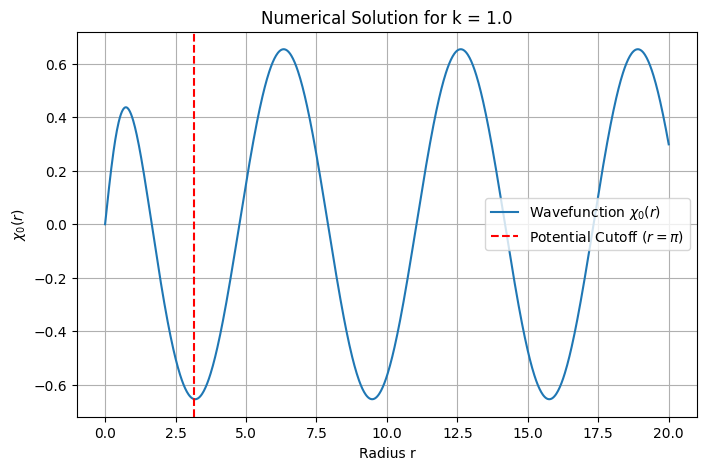

In [45]:
def calculate_phase_shift(chi_final, chi_prime_final, k, r_final):
    '''
    Extracts the s-wave phase shift delta_0 from the asymptotic solution.
    tan(k*r + delta) = k * (chi / chi')
    '''
    # Avoid division by zero
    if chi_prime_final == 0:
        return np.pi / 2 # Tangent is infinite

    # Using the matching condition at the boundary
    lhs = k * (chi_final / chi_prime_final)

    # The total argument is (k*r + delta)
    total_phase = np.arctan(lhs)

    delta = total_phase - k * r_final
    return delta

def verify_slope_independence(k, U0):
    '''
    Runs the simulation with two different initial slopes and compares results.
    '''
    _, _, final_state_1 = integrate_wavefunction(k, U0, initial_slope=1.0)
    delta_1 = calculate_phase_shift(final_state_1[0], final_state_1[1], k, 10.0)
    _, _, final_state_2 = integrate_wavefunction(k, U0, initial_slope=2.5)
    delta_2 = calculate_phase_shift(final_state_2[0], final_state_2[1], k, 10.0)

    print(f"Phase Shift (Slope=1.0): {delta_1:.6f}")
    print(f"Phase Shift (Slope=2.5): {delta_2:.6f}")
    print(f"Difference: {abs(delta_1 - delta_2)}")

def plot_solution(r, chi, k):
    '''
    Plots the radial wavefunction.
    '''
    plt.figure(figsize=(8, 5))
    plt.plot(r, chi, label=r"Wavefunction $\chi_0(r)$")
    plt.axvline(x=np.pi, color='r', linestyle='--', label=r"Potential Cutoff ($r=\pi$)")

    plt.title(f"Numerical Solution for k = {k}")
    plt.xlabel("Radius r")
    plt.ylabel(r"$\chi_0(r)$")
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
k_val = 1.0
U0_val = 6.0
initial_slope_val = 1.0

r, chi, final_state = integrate_wavefunction(k_val, U0_val, initial_slope_val)
delta = calculate_phase_shift(final_state[0], final_state[1], k_val, r[-1])
verify_slope_independence(k_val, U0_val)
plot_solution(r, chi, k_val)

We use the Runge-Kutta 4th Order (RK4) method to solve this initial value problem. The Schrödinger equation here is a second-order linear ODE which we split into a system of two coupled first-order ODEs. Unlike the simpler Euler method, which accumulates error linearly with step size $O(h)$, RK4 calculates the slope at four different points within a single step which provides a much higher degree of accuracy and stability.

The accuracy of the solution depends primarily on the step size $h$ relative to the oscillation frequency of the wavefunction. The RK4 method has a global truncation error of approximately $O(h^4)$. To maintain accuracy, the step size $h$ must be significantly smaller than the wavelength of the electron, $\lambda = 2\pi/k$, so that we can capture the oscillations and change in curvature of the sine wave.

We also verify that the choice of $\chi_0'(0)$ is irrelevant to the phase shift. Since the Schrödinger equation is linear and homogeneous, changing the initial slope simply scales the amplitude of the wavefunction by a constant factor $C$ which cancels out in the the phase shift ratio $\chi / \chi'$.

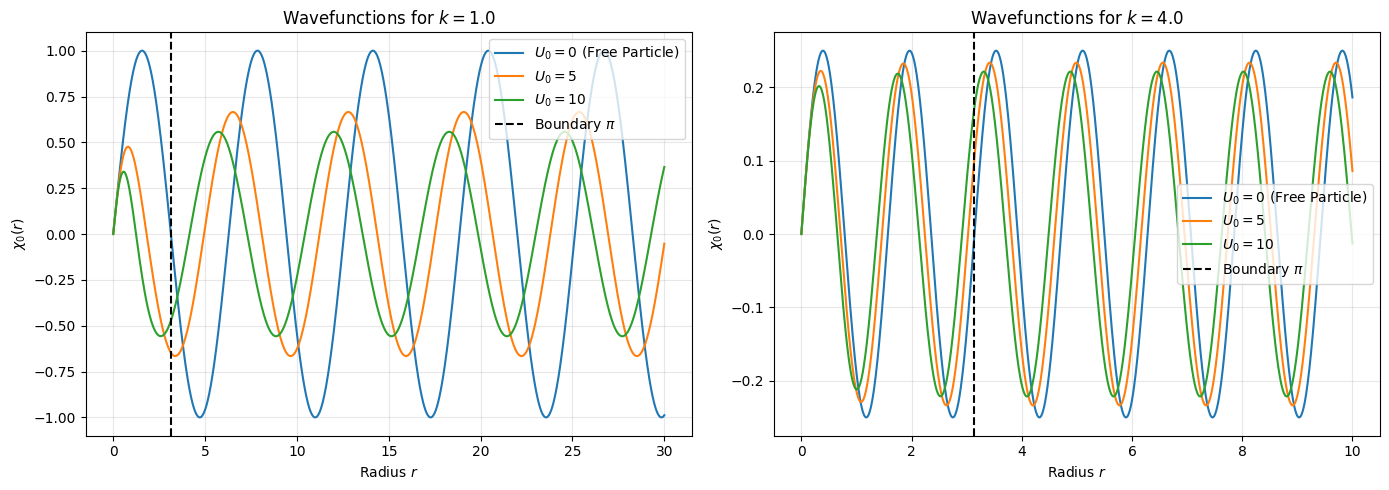

In [50]:
def run_investigation():
    k_values = [1.0, 4.0]
    U0_values = [0, 5, 10]
    r_max_values = [30, 10]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for idx, k in enumerate(k_values):
        ax = axes[idx]
        for U0 in U0_values:
            r, chi, _ = integrate_wavefunction(k, U0, r_max = r_max_values[idx])
            label = f"$U_0 = {U0}$"
            if U0 == 0:
                label += " (Free Particle)"
            ax.plot(r, chi, label=label)
        ax.axvline(x=np.pi, color='black', linestyle='--', label=r"Boundary $\pi$")
        ax.set_title(f"Wavefunctions for $k = {k}$")
        ax.set_xlabel("Radius $r$")
        ax.set_ylabel(r"$\chi_0(r)$")
        ax.grid(True, alpha=0.3)
        ax.legend()
    plt.tight_layout()
    plt.show()

run_investigation()


The case $U_0=0$ represents the free particle. Since the potential is zero everywhere, the equation simplifies to the harmonic oscillator equation $\chi'' = -k^2\chi$, hence the solution is purely sinusoidal $\chi_0(r) \propto \sin(kr)$.

As we increase $U_0$ from $0$ to $10$, the potential becomes more negative (deeper) in the region $r < \pi$. The Schrödinger equation term is $-(k^2 - U(r))$. A negative potential $U(r)$ adds to $k^2$, effectively increasing the local wavenumber inside the potential well. This causes the wavefunction to oscillate faster inside the region $r < \pi$. The first peak of the wavefunction moves to the left as $U_0$ increases which is a positive phase shift.

At low energy, the potential energy $U(r)$ is significant compared to the kinetic energy $E \propto k^2$. A change from $U_0=0$ to $U_0=10$ causes a drastic change in the shape of the wavefunction. Conversely, for high energy, the kinetic energy term $k^2$ is much larger. Adding the same potential depth is a smaller relative perturbation. While the phase shift still exists, the overall shape and frequency of the wave are dominated by the incident energy $k$, not the potential, so the curves lie closer together.